In [53]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc, roc_auc_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import seaborn as sns

In [54]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\SNA Pillar Add Aug20 GM")

# Define Key Functions

In [55]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [56]:
def lift_and_gain_df(data=None,target=None, prob=None, bucket = 10):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob]+jitter(data[prob]), bucket)
    grouped = data.groupby('bucket', as_index = False)
    liftstable = pd.DataFrame()
    liftstable['min_prob'] = grouped.agg(['min'])[prob].iloc[:,0]
    liftstable['max_prob'] = grouped.agg(['max'])[prob].iloc[:,0]
    liftstable['total']   = grouped.agg(['count'])[target].iloc[:,0]
    liftstable['bads']   = round(grouped.agg(['sum'])[target].iloc[:,0])
    liftstable['goods'] = round(grouped.agg(['sum'])['target0'].iloc[:,0])
    liftstable['%base'] = (liftstable.total / data[target].count())
    liftstable = liftstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    liftstable['cum%_base'] = (liftstable.total / data[target].count()).cumsum()
    liftstable['%bads'] = (liftstable['bads'] / data[target].sum())
    liftstable['%goods'] = (liftstable['goods'] / data['target0'].sum())
    liftstable['cum%_bads']=(liftstable['bads'] / data[target].sum()).cumsum()
    liftstable['cum%_goods']=(liftstable['bads'] / data['target0'].sum()).cumsum()

    
    liftstable['lift'] = np.round(liftstable['%bads']/liftstable['%base'] , 3)
    liftstable['cum_lift'] = np.round(liftstable['cum%_bads']/liftstable['cum%_base'] , 3)

    #Formating
    liftstable['%base']= liftstable['%base'].apply('{0:.2%}'.format)
    liftstable['%bads']= liftstable['%bads'].apply('{0:.2%}'.format)
    liftstable['%goods']= liftstable['%goods'].apply('{0:.2%}'.format)
    liftstable['cum%_bads']= liftstable['cum%_bads'].apply('{0:.2%}'.format)
    liftstable['cum%_goods']= liftstable['cum%_goods'].apply('{0:.2%}'.format)
    liftstable['cum%_base'] = liftstable['cum%_base'].apply('{0:.2%}'.format)

    liftstable.index = range(1,11)
    liftstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 13)
    return(liftstable)

In [57]:
def logit(x): 
    return np.log(x/(1-x))

# Value Add on POS_AUG20_GM

### Read Data

In [58]:
# df = pd.read_parquet('supervised_airtel_20210319')
# df.to_csv("upload_airtel_scores.csv", index = False)

In [59]:
##read datasets
df=pd.read_csv(os.getcwd()+r"\Data Files\export.csv")
df['TIME_DECISION_DATE'] = pd.to_datetime(df['TIME_DECISION_DATE'], format = '%d-%m-%y')
df['DECISION_MONTH'] = df['TIME_DECISION_DATE'].dt.strftime("%y-%m")

### Key Variables

In [60]:
ASIS_GM = "POS_AUG20_GM"
NEW_GM = "POS_AUG20_GM_WITH_SNA"
target = "RISK_FPD30"

### Define New GM (With SNA Pillar combined)

In [61]:
df.dropna(subset = [ASIS_GM], inplace = True)

In [62]:
df["NEW_GM_LINEAR"] = np.log(df[ASIS_GM]/(1-df[ASIS_GM])) + 0.766377*np.log(df["SNA_SCORE"]/(1-df["SNA_SCORE"]))+1.96

In [63]:
df[NEW_GM] = 1/(1+np.exp(-1*df["NEW_GM_LINEAR"]))

In [64]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,POS_AUG20_GM,POS_AUG20_GM_WO_PRODUCT,SNA_SCORE,RISK_FPD30,RISK_AGRF30,FLAG_1PCT_PHANTOM,GM_TYPE,DECISION_MONTH,NEW_GM_LINEAR,POS_AUG20_GM_WITH_SNA
0,328005523,2020-12-02,0.011203,0.012582,0.080989,0,1,0,LGBM,20-12,-4.381816,0.012348
1,328007018,2020-12-02,0.033027,NaN,0.045548,0,1,0,LOGISTIC,20-12,-3.748460,0.023012
2,328055445,2020-12-02,0.010096,0.014323,0.054388,0,1,0,LGBM,20-12,-4.814005,0.008050
3,327994614,2020-12-02,0.024383,NaN,0.080989,0,1,0,LOGISTIC,20-12,-3.590717,0.026838
4,328047276,2020-12-02,0.003432,0.005147,0.051778,0,1,0,LGBM,20-12,-5.939474,0.002626


### Gini Chart

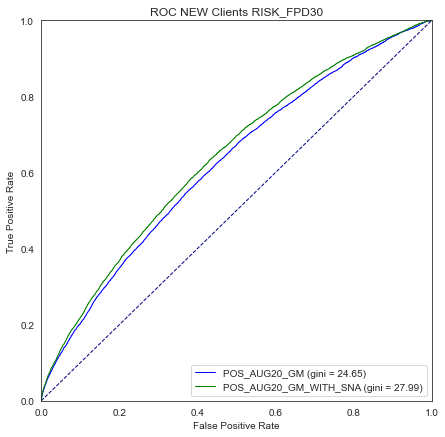

In [65]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(df[target],df[ASIS_GM])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label=ASIS_GM+' (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[target],df[NEW_GM])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label=NEW_GM+' (gini = %0.2f)' % ((2*roc_auc-1)*100))


ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC NEW Clients ' + target)
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [66]:
gini_dic = {}
for x in df["DECISION_MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if ASIS_GM not in gini_dic: 
            gini_dic[ASIS_GM] = []
        if NEW_GM not in gini_dic: 
            gini_dic[NEW_GM] = []
        
        gini_dic[ASIS_GM].append((2*roc_auc_score(df[df["DECISION_MONTH"]==x][target],df[df["DECISION_MONTH"]==x][ASIS_GM])-1)*100)
        gini_dic[NEW_GM].append((2*roc_auc_score(df[df["DECISION_MONTH"]==x][target],df[df["DECISION_MONTH"]==x][NEW_GM])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)
gini_df = gini_df.sort_values(by = 'index')

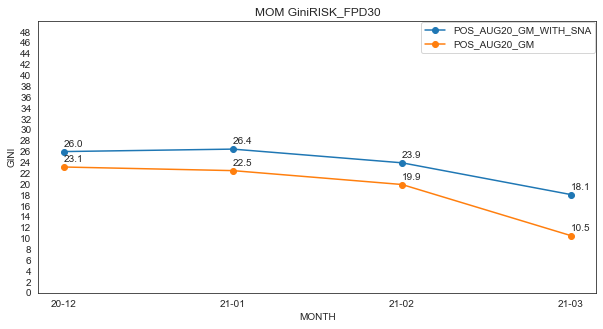

In [67]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df[NEW_GM], marker='o', scaley = False, label = NEW_GM)
ax1.plot(gini_df["MONTH"],gini_df[ASIS_GM], marker='o', scaley = False, label = ASIS_GM)


for i, txt in enumerate(gini_df[NEW_GM]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[NEW_GM][i]+0.9))
for i, txt in enumerate(gini_df[ASIS_GM]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[ASIS_GM][i]+0.9))

plt.legend(loc='upper right', borderaxespad=0.1)
plt.ylim(0,50)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,50,2))
ax1.set_title("MOM Gini" + target)
plt.show()

### Lifts and Gains Chart

In [68]:
#cum%_bads is gain_score
NEW_GM_score_lift = lift_and_gain_df(data=df,target=target, prob=NEW_GM, bucket=10)
ASIS_GM_score_lift = lift_and_gain_df(data=df,target=target, prob=ASIS_GM, bucket=10)

### Cumulative Lift Chart 

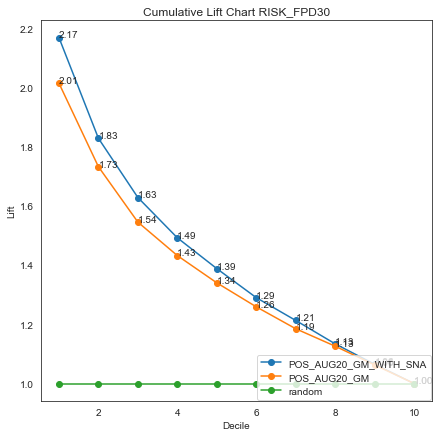

In [69]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)

ax1.plot(NEW_GM_score_lift.index,NEW_GM_score_lift["cum_lift"], label = NEW_GM, marker='o')
for i, txt in enumerate(NEW_GM_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (NEW_GM_score_lift.index[i], NEW_GM_score_lift["cum_lift"][i+1]))

ax1.plot(ASIS_GM_score_lift.index,ASIS_GM_score_lift["cum_lift"], label = ASIS_GM, marker='o')
for i, txt in enumerate(ASIS_GM_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (ASIS_GM_score_lift.index[i], ASIS_GM_score_lift["cum_lift"][i+1]))

ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart "+target)
plt.show()    


### Population Shift

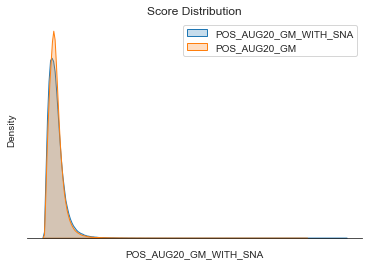

In [70]:
sns.set_style("white")
plot = sns.kdeplot(df[NEW_GM], shade=True, label = NEW_GM )
plot = sns.kdeplot(df[ASIS_GM], shade=True, label = ASIS_GM )
plot.set(yticklabels=[], xticklabels = [])
sns.despine(left=True)
plt.legend()
plt.title("Score Distribution")
plt.show()


### Correlation Chart

<AxesSubplot:>

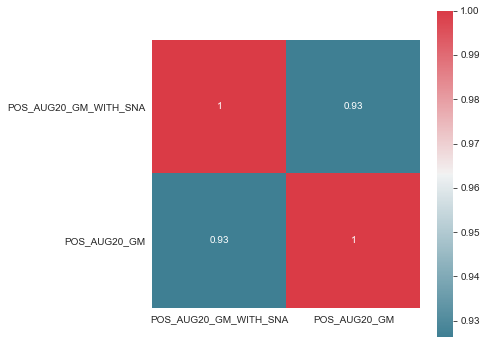

In [71]:
import seaborn as sns

columns = [NEW_GM,ASIS_GM]

f, ax = plt.subplots(figsize=(6, 6))
corr = df[columns].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot = True)

# Value Add on POS_AUG20_GM_WO_PRODUCT

### Read Data

In [72]:
# df = pd.read_parquet('supervised_airtel_20210319')
# df.to_csv("upload_airtel_scores.csv", index = False)

In [73]:
##read datasets
df=pd.read_csv(os.getcwd()+r"\Data Files\export.csv")
df['TIME_DECISION_DATE'] = pd.to_datetime(df['TIME_DECISION_DATE'], format = '%d-%m-%y')
df['DECISION_MONTH'] = df['TIME_DECISION_DATE'].dt.strftime("%y-%m")

### Key Variables

In [74]:
ASIS_GM = "POS_AUG20_GM_WO_PRODUCT"
NEW_GM = "POS_AUG20_GM_WO_PRODUCT_WITH_SNA"
target = "RISK_FPD30"

### Define New GM (With SNA Pillar combined)

In [75]:
df.dropna(subset = [ASIS_GM], inplace = True)

In [76]:
df["NEW_GM_LINEAR"] = np.log(df[ASIS_GM]/(1-df[ASIS_GM])) + 0.766377*np.log(df["SNA_SCORE"]/(1-df["SNA_SCORE"]))+1.96

In [77]:
df[NEW_GM] = 1/(1+np.exp(-1*df["NEW_GM_LINEAR"]))

### Gini Chart

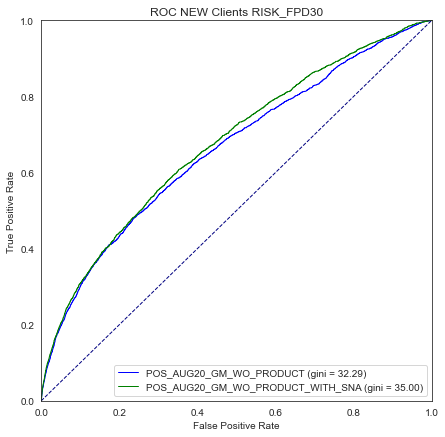

In [78]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(df[target],df[ASIS_GM])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label=ASIS_GM+' (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[target],df[NEW_GM])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label=NEW_GM+' (gini = %0.2f)' % ((2*roc_auc-1)*100))


ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC NEW Clients ' + target)
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [79]:
gini_dic = {}
for x in df["DECISION_MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if ASIS_GM not in gini_dic: 
            gini_dic[ASIS_GM] = []
        if NEW_GM not in gini_dic: 
            gini_dic[NEW_GM] = []
        
        gini_dic[ASIS_GM].append((2*roc_auc_score(df[df["DECISION_MONTH"]==x][target],df[df["DECISION_MONTH"]==x][ASIS_GM])-1)*100)
        gini_dic[NEW_GM].append((2*roc_auc_score(df[df["DECISION_MONTH"]==x][target],df[df["DECISION_MONTH"]==x][NEW_GM])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)
gini_df = gini_df.sort_values(by = 'index')

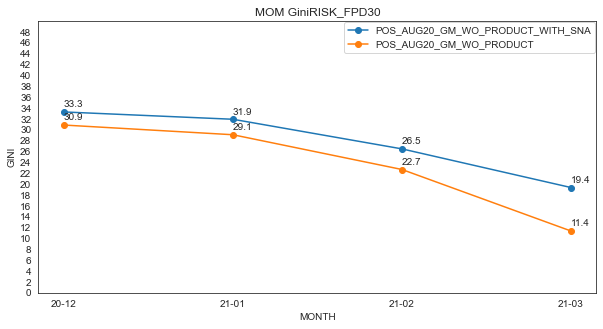

In [80]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df[NEW_GM], marker='o', scaley = False, label = NEW_GM)
ax1.plot(gini_df["MONTH"],gini_df[ASIS_GM], marker='o', scaley = False, label = ASIS_GM)


for i, txt in enumerate(gini_df[NEW_GM]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[NEW_GM][i]+0.9))
for i, txt in enumerate(gini_df[ASIS_GM]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[ASIS_GM][i]+0.9))

plt.legend(loc='upper right', borderaxespad=0.1)
plt.ylim(0,50)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,50,2))
ax1.set_title("MOM Gini" + target)
plt.show()

### Lifts and Gains Chart

In [81]:
#cum%_bads is gain_score
NEW_GM_score_lift = lift_and_gain_df(data=df,target=target, prob=NEW_GM, bucket=10)
ASIS_GM_score_lift = lift_and_gain_df(data=df,target=target, prob=ASIS_GM, bucket=10)

### Cumulative Lift Chart 

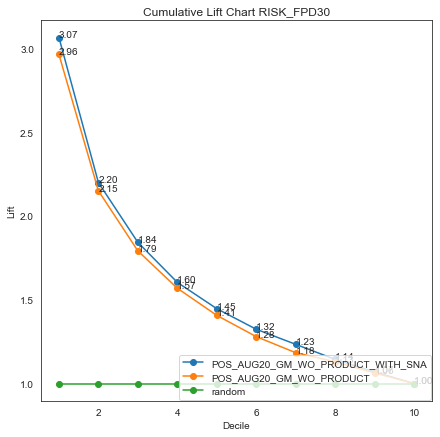

In [82]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)

ax1.plot(NEW_GM_score_lift.index,NEW_GM_score_lift["cum_lift"], label = NEW_GM, marker='o')
for i, txt in enumerate(NEW_GM_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (NEW_GM_score_lift.index[i], NEW_GM_score_lift["cum_lift"][i+1]))

ax1.plot(ASIS_GM_score_lift.index,ASIS_GM_score_lift["cum_lift"], label = ASIS_GM, marker='o')
for i, txt in enumerate(ASIS_GM_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (ASIS_GM_score_lift.index[i], ASIS_GM_score_lift["cum_lift"][i+1]))

ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart "+target)
plt.show()    


### Population Shift

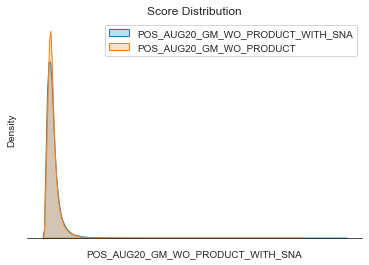

In [83]:
sns.set_style("white")
plot = sns.kdeplot(df[NEW_GM], shade=True, label = NEW_GM )
plot = sns.kdeplot(df[ASIS_GM], shade=True, label = ASIS_GM )
plot.set(yticklabels=[], xticklabels = [])
sns.despine(left=True)
plt.legend()
plt.title("Score Distribution")
plt.show()


### Correlation Chart

<AxesSubplot:>

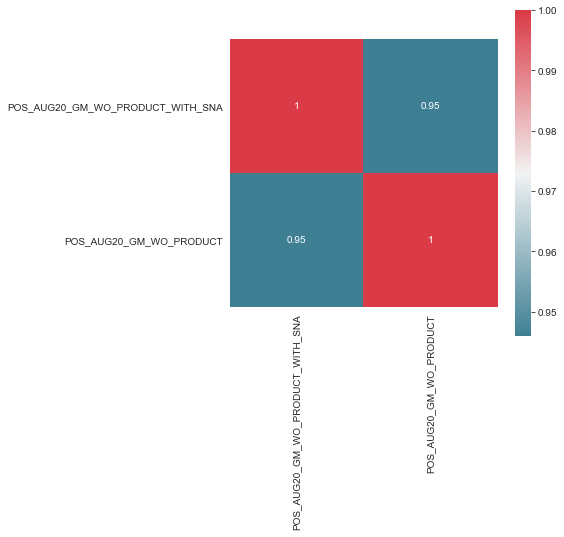

In [84]:
import seaborn as sns

columns = [NEW_GM,ASIS_GM]

f, ax = plt.subplots(figsize=(6, 6))
corr = df[columns].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot = True)